# Volumetry Analysis
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32) PPMI NC (116) and ADNI NC (308), QC not included.

## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, site, eTIV

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
mni_file  = data_dir/'MNI_Des-cere_preped.csv'
adni_ppmi_file = data_dir/'ADNI-PPMI_Des-cere_preped.csv'

mni_df       = pd.read_csv(mni_file , sep=',', header=0, index_col=0);
adni_ppmi_df = pd.read_csv(adni_ppmi_file , sep=',', header=0, index_col=0);

#excluding list
data_df = pd.concat([mni_df, adni_ppmi_df])
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
data_df=data_df.drop(columns=drop_col_list);

210926-06:09:34,536 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
# prepare data for this script
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
analysis_list = ['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels
curr_df = data_df[analysis_list].copy()
curr_df.loc[:, 'Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
curr_df.loc[:, 'Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];
#print(list(data_df.columns))

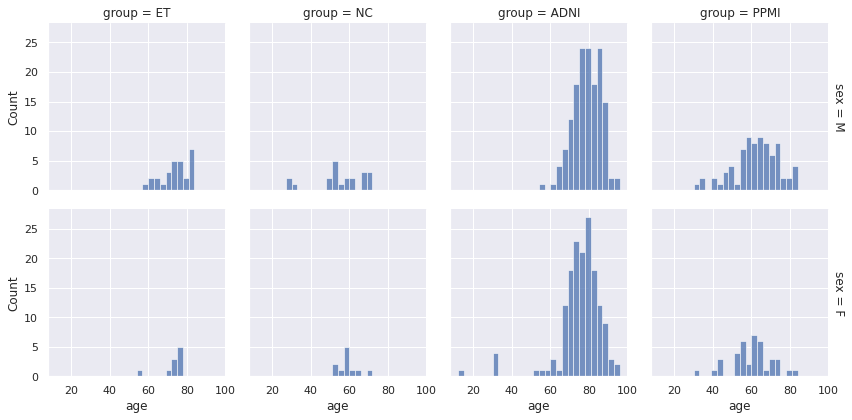

In [3]:
# plot demographic age/sex/group distributions 2*3
sns.set_theme(style="darkgrid")
sns.displot(
    curr_df, x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

In [4]:
### statistical analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_et_biomarker.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es

# calculate the Infra tentorial volumen approximately by eTIV-SupraTentorialVol
curr_df.loc[:,'InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol'];
df=curr_df.copy()
# get the data for ET/all NC analysis
# get indicator variable
df.loc[:,'male']=[int(x=='M') for x in df['sex']]
df.loc[:,'is_mni']=[1 if int(x=='ET' or x=='NC') else 0 for x in df['group']]
df.loc[:,'is_ppmi']=[int(x=='PPMI') for x in df['group']]
df.loc[:,'is_adni']=[int(x=='ADNI') for x in df['group']]
df.loc[:,'group']=[x if x=='ET' else 'NC' for x in df['group'] ]
alpha_=5; n_permu_=5000;

## covariate
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];

sts_df = df[info_list+cerebellum_list+lobular_list];
tar_list = cerebellum_list+lobular_list;

sts_tests_list = ['Cohen_d', 'rank_sum']; 
group_list = ['ET','NC'];

## Volumentry analysis for cerebellar volumetry for ET/NC comparison
    1. Experiment 1: without controling for any covariates;
    2. Experiment 2: control age/sex/site/eTIV with rm control group method;
    3. Experiment 3: control age/sex/site/infratentorialVolume with rm control group method;
    2. Experiment 4: control age/sex/site/eTIV with direct proportion adjustment method;
    3. Experiment 5: control age/sex/site/infratentorialVolume with direct proportion adjustment method;

,ES,ROI,group,p_val,test
0,0.008585,Left_Cerebellum_Cortex,ET_NC,9.284000e-01,Cohen_d
1,0.468587,Left_Cerebellum_Cortex,ET_NC,6.393647e-01,rank_sum
2,0.066752,Left_Cerebellum_White_Matter,ET_NC,6.868000e-01,Cohen_d
3,0.763667,Left_Cerebellum_White_Matter,ET_NC,4.450656e-01,rank_sum
4,0.074673,Right_Cerebellum_Cortex,ET_NC,6.268000e-01,Cohen_d
5,0.794356,Right_Cerebellum_Cortex,ET_NC,4.269885e-01,rank_sum
6,-0.117832,Right_Cerebellum_White_Matter,ET_NC,4.760000e-01,Cohen_d
7,-0.411342,Right_Cerebellum_White_Matter,ET_NC,6.808220e-01,rank_sum
8,0.042599,Cerebellum_Cortex,ET_NC,7.728000e-01,Cohen_d
9,0.672783,Cerebellum_Cortex,ET_NC,5.010856e-01,rank_sum


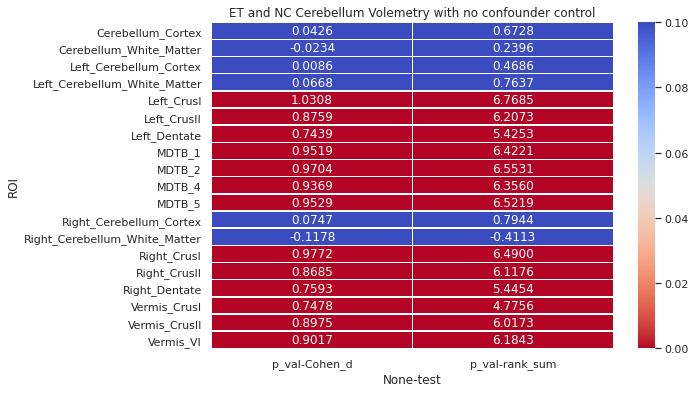

In [5]:
# Experiment 1: volumentry analysis for cerebellar gray and white matter without correction.
res_cere_gw = cal_es(df, tar_list, alpha_, n_permu_, sts_tests_list, group_list);

C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
vis_df = res_cere_gw.copy()
#vis_df['ROI']=vis_df['ROI'].map(lambda x: x[0:-14]);
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
ax1=sns.heatmap(p_df, annot=es_df, fmt=".4f", linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('ET and NC Cerebellum Volemetry with no confounder control')
display(res_cere_gw)

Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_1_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_2_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_4_eTIV

,ES,ROI,group,p_val,test
0,0.010972,Left_Cerebellum_Cortex_eTIV_age_male_is_mni_is...,ET_NC,0.936000,Cohen_d
1,-0.018885,Left_Cerebellum_Cortex_eTIV_age_male_is_mni_is...,ET_NC,0.984933,rank_sum
2,0.297467,Left_Cerebellum_White_Matter_eTIV_age_male_is_...,ET_NC,0.075600,Cohen_d
3,1.992381,Left_Cerebellum_White_Matter_eTIV_age_male_is_...,ET_NC,0.046329,rank_sum
4,-0.034375,Right_Cerebellum_Cortex_eTIV_age_male_is_mni_i...,ET_NC,0.819600,Cohen_d
5,-0.344654,Right_Cerebellum_Cortex_eTIV_age_male_is_mni_i...,ET_NC,0.730355,rank_sum
6,0.013499,Right_Cerebellum_White_Matter_eTIV_age_male_is...,ET_NC,0.926400,Cohen_d
7,0.161704,Right_Cerebellum_White_Matter_eTIV_age_male_is...,ET_NC,0.871539,rank_sum
8,-0.012131,Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi...,ET_NC,0.926000,Cohen_d
9,-0.232523,Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi...,ET_NC,0.816132,rank_sum


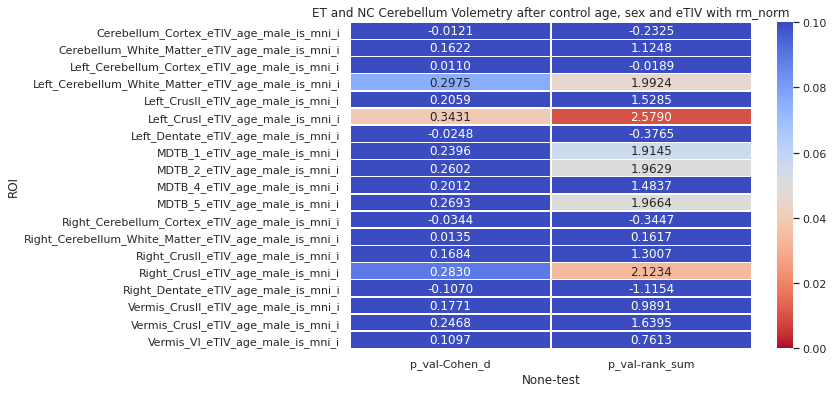

In [6]:
# Experiment 2: volumentry analysis for cerebellar gray and white matter for ET controling age/set/eTIV with rm_norm. 
dat_cere_gw, cere_gw_col = ctr_tiv(df, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
res_cere_gw = cal_es(dat_cere_gw, cere_gw_col, alpha_, n_permu_, sts_tests_list, group_list);

C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
vis_df = res_cere_gw.copy()
vis_df['ROI']=vis_df['ROI'].map(lambda x: x[0:-14]);
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
ax1=sns.heatmap(p_df, annot=es_df, fmt=".4f", linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('ET and NC Cerebellum Volemetry after control age, sex and eTIV with rm_norm')
display(res_cere_gw)

Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusI_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusII_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusII_InfraTentorialVol_age_male_is_mni_is_ppmi_is_adni', 'Left_Dentate_InfraTentorialVol_age_male_is_

,ES,ROI,group,p_val,test
0,-0.028709,Left_Cerebellum_Cortex_InfraTentorialVol_age_m...,ET_NC,0.840000,Cohen_d
1,-0.147540,Left_Cerebellum_Cortex_InfraTentorialVol_age_m...,ET_NC,0.882706,rank_sum
2,0.286926,Left_Cerebellum_White_Matter_InfraTentorialVol...,ET_NC,0.088800,Cohen_d
3,1.994741,Left_Cerebellum_White_Matter_InfraTentorialVol...,ET_NC,0.046071,rank_sum
4,-0.067357,Right_Cerebellum_Cortex_InfraTentorialVol_age_...,ET_NC,0.671200,Cohen_d
5,-0.520521,Right_Cerebellum_Cortex_InfraTentorialVol_age_...,ET_NC,0.602700,rank_sum
6,0.008216,Right_Cerebellum_White_Matter_InfraTentorialVo...,ET_NC,0.951200,Cohen_d
7,0.203015,Right_Cerebellum_White_Matter_InfraTentorialVo...,ET_NC,0.839123,rank_sum
8,-0.048857,Cerebellum_Cortex_InfraTentorialVol_age_male_i...,ET_NC,0.747200,Cohen_d
9,-0.332850,Cerebellum_Cortex_InfraTentorialVol_age_male_i...,ET_NC,0.739247,rank_sum


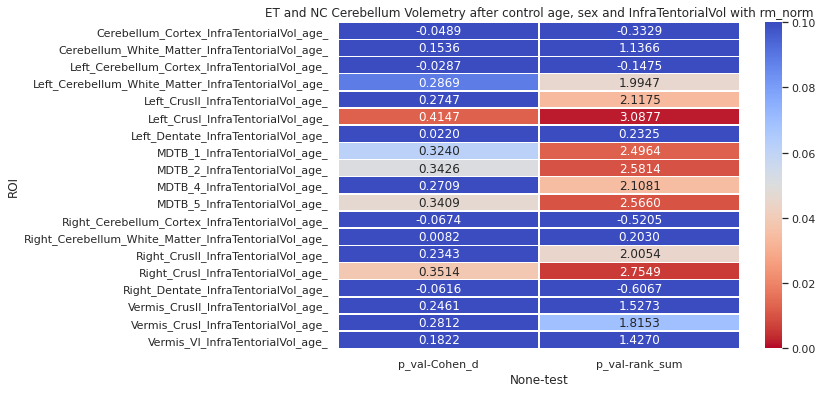

In [7]:
# Experiment 3: volumentry analysis for cerebellar volumentry for ET/NC, controling for age/sex/infratentorial
dat_cere_gw, cere_gw_col = ctr_tiv(df, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
res_cere_gw = cal_es(dat_cere_gw, cere_gw_col, alpha_, n_permu_, sts_tests_list, group_list);

C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
vis_df = res_cere_gw.copy()
vis_df['ROI']=vis_df['ROI'].map(lambda x: x[0:-27]);
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
ax1=sns.heatmap(p_df, annot=es_df, fmt=".4f", linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('ET and NC Cerebellum Volemetry after control age, sex and InfraTentorialVol with rm_norm')
display(res_cere_gw)

Using  dpa
New columns 38 :  ['Left_Cerebellum_Cortex_dpa', 'Left_Cerebellum_White_Matter_dpa', 'Right_Cerebellum_Cortex_dpa', 'Right_Cerebellum_White_Matter_dpa', 'Cerebellum_Cortex_dpa', 'Cerebellum_White_Matter_dpa', 'Vermis_VI_dpa', 'Vermis_CrusI_dpa', 'Vermis_CrusII_dpa', 'Left_CrusI_dpa', 'Right_CrusI_dpa', 'Left_CrusII_dpa', 'Right_CrusII_dpa', 'Left_Dentate_dpa', 'Right_Dentate_dpa', 'MDTB_1_dpa', 'MDTB_2_dpa', 'MDTB_4_dpa', 'MDTB_5_dpa', 'Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_dpa_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_d

,ES,ROI,group,p_val,test
0,-0.023077,Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_...,ET_NC,0.870400,Cohen_d
1,-0.491013,Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_...,ET_NC,0.623417,rank_sum
2,0.235336,Left_Cerebellum_White_Matter_dpa_age_male_is_m...,ET_NC,0.156800,Cohen_d
3,1.751595,Left_Cerebellum_White_Matter_dpa_age_male_is_m...,ET_NC,0.079843,rank_sum
4,-0.069853,Right_Cerebellum_Cortex_dpa_age_male_is_mni_is...,ET_NC,0.672800,Cohen_d
5,-0.710553,Right_Cerebellum_Cortex_dpa_age_male_is_mni_is...,ET_NC,0.477361,rank_sum
6,-0.027787,Right_Cerebellum_White_Matter_dpa_age_male_is_...,ET_NC,0.850800,Cohen_d
7,-0.109770,Right_Cerebellum_White_Matter_dpa_age_male_is_...,ET_NC,0.912592,rank_sum
8,-0.047413,Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_...,ET_NC,0.765200,Cohen_d
9,-0.606685,Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_...,ET_NC,0.544060,rank_sum


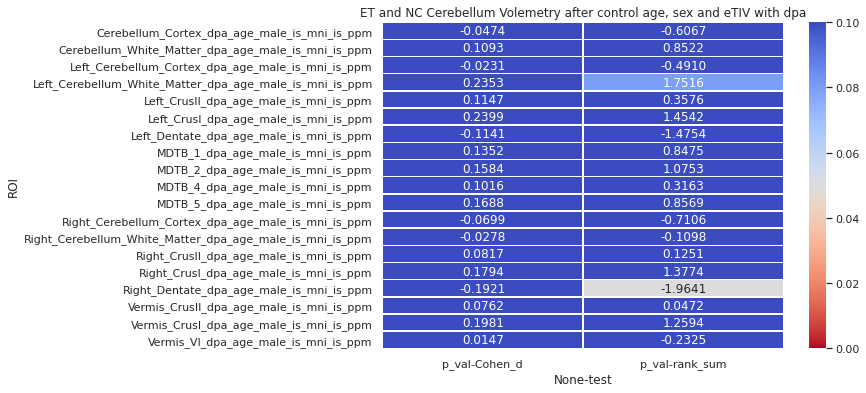

In [8]:
# Experiment 4: volumentry analysis for cerebellar gray and white matter for ET
dat_cere_gw, cere_gw_col = ctr_tiv(df, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
res_cere_gw = cal_es(dat_cere_gw, cere_gw_col[int(len(cere_gw_col)/2):], alpha_, n_permu_, sts_tests_list, group_list);

C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
vis_df = res_cere_gw.copy()
vis_df['ROI']=vis_df['ROI'].map(lambda x: x[0:-9]);
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
ax1=sns.heatmap(p_df, annot=es_df, fmt=".4f", linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('ET and NC Cerebellum Volemetry after control age, sex and eTIV with dpa')
display(res_cere_gw)

Using  dpa
New columns 38 :  ['Left_Cerebellum_Cortex_dpa', 'Left_Cerebellum_White_Matter_dpa', 'Right_Cerebellum_Cortex_dpa', 'Right_Cerebellum_White_Matter_dpa', 'Cerebellum_Cortex_dpa', 'Cerebellum_White_Matter_dpa', 'Vermis_VI_dpa', 'Vermis_CrusI_dpa', 'Vermis_CrusII_dpa', 'Left_CrusI_dpa', 'Right_CrusI_dpa', 'Left_CrusII_dpa', 'Right_CrusII_dpa', 'Left_Dentate_dpa', 'Right_Dentate_dpa', 'MDTB_1_dpa', 'MDTB_2_dpa', 'MDTB_4_dpa', 'MDTB_5_dpa', 'Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_dpa_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_d

,ES,ROI,group,p_val,test
0,-0.489190,Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_...,ET_NC,0.010400,Cohen_d
1,-3.590534,Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_...,ET_NC,0.000330,rank_sum
2,-0.204048,Left_Cerebellum_White_Matter_dpa_age_male_is_m...,ET_NC,0.228800,Cohen_d
3,-0.989108,Left_Cerebellum_White_Matter_dpa_age_male_is_m...,ET_NC,0.322610,rank_sum
4,-0.520005,Right_Cerebellum_Cortex_dpa_age_male_is_mni_is...,ET_NC,0.007200,Cohen_d
5,-3.753419,Right_Cerebellum_Cortex_dpa_age_male_is_mni_is...,ET_NC,0.000174,rank_sum
6,-0.391461,Right_Cerebellum_White_Matter_dpa_age_male_is_...,ET_NC,0.028800,Cohen_d
7,-2.449165,Right_Cerebellum_White_Matter_dpa_age_male_is_...,ET_NC,0.014319,rank_sum
8,-0.507060,Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_...,ET_NC,0.008800,Cohen_d
9,-3.713288,Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_...,ET_NC,0.000205,rank_sum


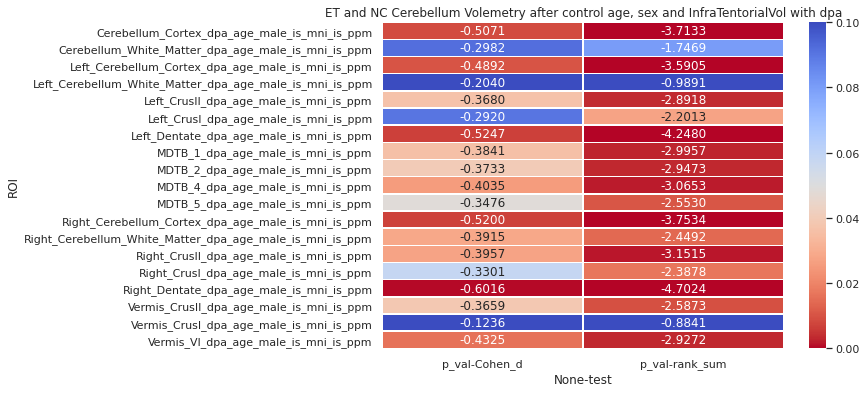

In [9]:
# Experiment 5: volumentry analysis for cerebellar gray and white matter for ET
dat_cere_gw, cere_gw_col = ctr_tiv(df, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
res_cere_gw = cal_es(dat_cere_gw, cere_gw_col[int(len(cere_gw_col)/2):], alpha_, n_permu_, sts_tests_list, group_list);

C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
vis_df = res_cere_gw.copy()
vis_df['ROI']=vis_df['ROI'].map(lambda x: x[0:-9]);
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
ax1=sns.heatmap(p_df, annot=es_df, fmt=".4f", linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('ET and NC Cerebellum Volemetry after control age, sex and InfraTentorialVol with dpa')
display(res_cere_gw)

Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusI_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusII_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusII_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Left_Dentate_cerebellumVol_age_male_is_mni_is_ppmi_is_adni', 'Right_Dentate_cerebellumVol_age_m

,ES,ROI,group,p_val,test
0,-0.092139,Left_Cerebellum_Cortex_cerebellumVol_age_male_...,ET_NC,0.581200,Cohen_d
1,-0.937174,Left_Cerebellum_Cortex_cerebellumVol_age_male_...,ET_NC,0.348669,rank_sum
2,0.362203,Left_Cerebellum_White_Matter_cerebellumVol_age...,ET_NC,0.037600,Cohen_d
3,2.911850,Left_Cerebellum_White_Matter_cerebellumVol_age...,ET_NC,0.003593,rank_sum
4,-0.220938,Right_Cerebellum_Cortex_cerebellumVol_age_male...,ET_NC,0.194800,Cohen_d
5,-1.807070,Right_Cerebellum_Cortex_cerebellumVol_age_male...,ET_NC,0.070751,rank_sum
6,-0.025946,Right_Cerebellum_White_Matter_cerebellumVol_ag...,ET_NC,0.863600,Cohen_d
7,0.337572,Right_Cerebellum_White_Matter_cerebellumVol_ag...,ET_NC,0.735686,rank_sum
8,-0.179647,Cerebellum_Cortex_cerebellumVol_age_male_is_mn...,ET_NC,0.291200,Cohen_d
9,-1.782284,Cerebellum_Cortex_cerebellumVol_age_male_is_mn...,ET_NC,0.074703,rank_sum


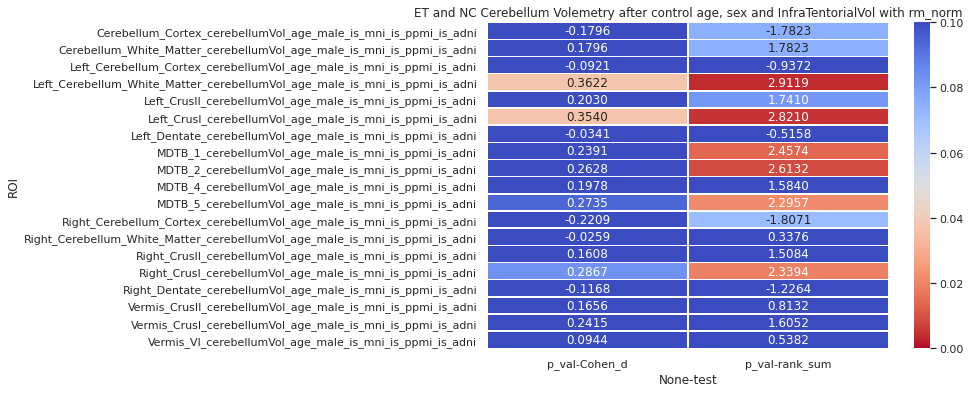

In [10]:
# Experiment 5: volumentry analysis for cerebellar gray and white matter for ET
tmp_df = df.copy() 
tmp_df['cerebellumVol']=tmp_df['Cerebellum_Cortex']+tmp_df['Cerebellum_White_Matter']
dat_cere_gw, cere_gw_col = ctr_tiv(tmp_df, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
res_cere_gw = cal_es(dat_cere_gw, cere_gw_col, alpha_, n_permu_, sts_tests_list, group_list);

C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
vis_df = res_cere_gw.copy()
vis_df['ROI']=vis_df['ROI'].map(lambda x: x);
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
ax1=sns.heatmap(p_df, annot=es_df, fmt=".4f", linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('ET and NC Cerebellum Volemetry after control age, sex and Cerebellum with rm_norm')
display(res_cere_gw)

Using  dpa
New columns 38 :  ['Left_Cerebellum_Cortex_dpa', 'Left_Cerebellum_White_Matter_dpa', 'Right_Cerebellum_Cortex_dpa', 'Right_Cerebellum_White_Matter_dpa', 'Cerebellum_Cortex_dpa', 'Cerebellum_White_Matter_dpa', 'Vermis_VI_dpa', 'Vermis_CrusI_dpa', 'Vermis_CrusII_dpa', 'Left_CrusI_dpa', 'Right_CrusI_dpa', 'Left_CrusII_dpa', 'Right_CrusII_dpa', 'Left_Dentate_dpa', 'Right_Dentate_dpa', 'MDTB_1_dpa', 'MDTB_2_dpa', 'MDTB_4_dpa', 'MDTB_5_dpa', 'Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_dpa_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_dpa_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_d

,ES,ROI,group,p_val,test
0,-0.071630,Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_...,ET_NC,0.677200,Cohen_d
1,-0.801438,Left_Cerebellum_Cortex_dpa_age_male_is_mni_is_...,ET_NC,0.422878,rank_sum
2,0.328750,Left_Cerebellum_White_Matter_dpa_age_male_is_m...,ET_NC,0.063200,Cohen_d
3,2.623852,Left_Cerebellum_White_Matter_dpa_age_male_is_m...,ET_NC,0.008694,rank_sum
4,-0.185176,Right_Cerebellum_Cortex_dpa_age_male_is_mni_is...,ET_NC,0.275200,Cohen_d
5,-1.521433,Right_Cerebellum_Cortex_dpa_age_male_is_mni_is...,ET_NC,0.128151,rank_sum
6,-0.055385,Right_Cerebellum_White_Matter_dpa_age_male_is_...,ET_NC,0.734800,Cohen_d
7,0.195933,Right_Cerebellum_White_Matter_dpa_age_male_is_...,ET_NC,0.844662,rank_sum
8,-0.147207,Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_...,ET_NC,0.373600,Cohen_d
9,-1.556843,Cerebellum_Cortex_dpa_age_male_is_mni_is_ppmi_...,ET_NC,0.119508,rank_sum


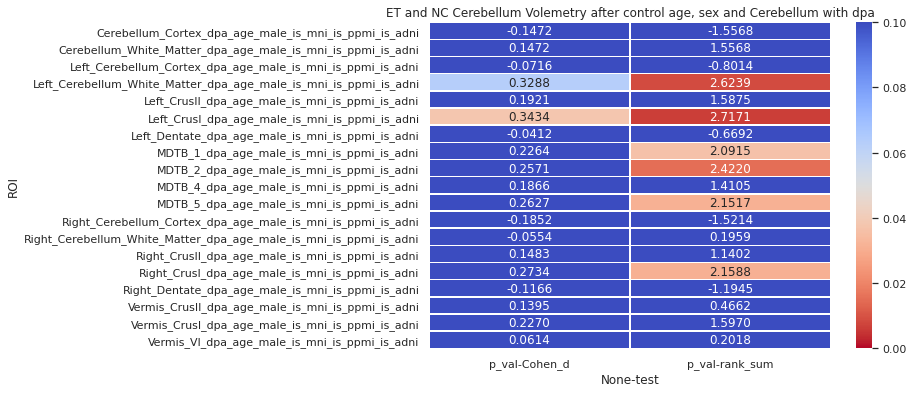

In [12]:
# Experiment 5: volumentry analysis for cerebellar gray and white matter for ET
tmp_df = df.copy() 
tmp_df['cerebellumVol']=tmp_df['Cerebellum_Cortex']+tmp_df['Cerebellum_White_Matter']
dat_cere_gw, cere_gw_col = ctr_tiv(tmp_df, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
res_cere_gw = cal_es(dat_cere_gw, cere_gw_col[int(len(cere_gw_col)/2):], alpha_, n_permu_, sts_tests_list, group_list);

C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
vis_df = res_cere_gw.copy()
vis_df['ROI']=vis_df['ROI'].map(lambda x: x);
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
ax1=sns.heatmap(p_df, annot=es_df, fmt=".4f", linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('ET and NC Cerebellum Volemetry after control age, sex and Cerebellum with dpa')
display(res_cere_gw)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts

# basic GLM
covariate_model_str = '~age+sex+InfraTentorialVol+C(group, Treatment(reference="NC"))';
#covariate_dict = glm_test(sts_df, tar_list, covariate_model_str);
#covariate_df   = sts_test(tar_list, sts_df, stats_cols, alpha, n_permu, 'covariate')
df = curr_df[(curr_df['group']=='ET')|(curr_df['group']=='NC')]

dat, new_col = ctr_tiv(df, cerebellum_list, 'eTIV', ['age','male'], 'asm')